# Controlling Glucose Metabolism in Yeast
(Based on a final project submitted by Seth Woodbury to BIOEN 599, March, 2024, University of Washington)

# Preliminaries

In [ ]:
# Set to True if running in colab
if False:
    # The following cell may have to be run twice, the second time using "Restart session and runall".
    !pip install control==0.9.4
    !pip install controlSBML

In [ ]:
import controlSBML as ctl
import numpy as np

In [ ]:
TIMES = np.linspace(0, 10, 100)

# 1. Problem Description & Control Objectives

**IMPORTANT LINKS:**

<u>Selected Biomodel:</u> Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli

<u>Biomodel URL:</u> https://www.ebi.ac.uk/biomodels/BIOMD0000000571

<u>Publication URL:</u> https://www.embopress.org/doi/full/10.1038/msb4100201

**PROBLEM DESCRIPTION:**

Industrial bioreactors culturing engineered microbes present a cost-effective, highly efficient, minimal-resource cost, and eco-friendly method of producing large quantities of desirable proteins and complex organic compounds for societal use (e.g., academia, therapeutics, industrial chemistry, biotechnology sectors). The biological problem I am addressing regards controlling Escherichia coli (E. coli) glucose uptake for such industrial microbe engineering purposes since they are the most well-studied and commonly used microbe. From a bioreactor production standpoint, it is desirable to have E. coli uptake as much glucose as possible for the ultimate production of ATP and the desired plasmid product(s) they were engineered to produce (i.e., protein products or protein machinery to make small organic molecules). However, E. coli have evolved to highly regulate their glucose uptake for the optimal cooperative survival and proliferation of their colonies; if they sense low glucose in the environment, they will try to use other carbon sources and metabolites for energy and they will shift toward conservative/catabolic metabolic processes rather than the anabolic ones we want them to perform. Ideally, we want E. coli in a bioreactor to initially divide to a certain concentration, then we want to induce them to grow as fat as possible (taking in the maximal possible glucose as fuel) to become full of our intended product before we lyse them all to harvest our product.

E. coli have evolved a complex phosphotransferase system that acts in a biological circuit to control the transfer of glucose into the cell while simultaneously phosphorylating it. The specific biological problem that I will be engineering in this system is how to control and enhance the concentration of ``phosphorylated EI`` or ``EI_P`` from the gene ptsI. The phosphotransfer of the phosphate on phosphoenolpyruvate to EI making EI_P is the first step in the phosphotransferase cascade system that ultimately phosphorylates glucose and transports it into the cell. This reaction is also thought to be the rate-limiting step in glucose intake so aiming to control and upregulate EI_P concentration will push equilibrium towards a higher glucose intake.

**CONTROL OBJECTIVES:**

In the given model, the extracellular glucose concentration is held constant which could mimic a bioreactor that is continuously feeding E. coli glucose while they divide and grow before their plasmid expression is induced. At t = 500 minutes in the model the glucose levels drop instantaneously by several orders of magnitude to cause a perturbation (see below). As a reminder, we want to resist ``EI_P`` decrease at all costs and ideally minimize its increase from the reverse of the phosphotransferase cascade since the last step depends partially on glucose concentration and each phosphate transfer is reversible. **Thus, our control objectives are:**
* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs but ideally [2.4e-7 M, 4.0e-7 M] for at least 720 minutes (12 hours).
* Minimize any potential concentration oscillations and keep the oscillations within the concentration range above.
* Converge to a stable, steady-state system after the glucose decrease at t = 500 minutes within 120 minutes (t = 620 minutes).
* With each additional step this setting time should also be within t = 30 minutes & the final ``EI_P`` should steady out.

Achieving these control objectives will allow our engineered E. coli to keep maximally uptaking glucose even after we shut down its continuous flow into the bioreactor. Keeping the ``EI_P`` range above 2.4e-7 M is significant because this is its steady-state concentration at glucose concentrations that are magnitudes higher at t < 500 minutes, so maintaining an ``EI_P`` this high after t = 500 minutes will mean the E. coli are still uptaking glucose at a similar rate as before. Keeping it below 3.4e-7 M is a good sign that the rest of the phosphotransferase cascade is not backing up or slowing down significantly. Cells enjoy homeostasis and consistency, so minimizing ``EI_P`` oscillations will be important to not throw off other equilibriums that are not necessarily modeled here with respect to glucose uptake, we want a continuous flux of glucose coming in that keeps our E. coli busy at making proteins. Finally, 30 minutes is a pretty short time for E. coli so it would be desirable if the system could converge within 30 minutes so the E. coli are not thrown out of homeostasis.

## Antimony Model

In [ ]:
# Assign file URL to a variable
TIMES = np.linspace(000, 1500, 5000)
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1501300000/3/BIOMD0000000571_url.xml"

# Create tellurium SBML model & print the antimony
CTLSB = ctl.ControlSBML(URL, xlabel="time (min)", times=TIMES)

## Preliminary Investigation

We begin by plotting the time course of all species in the simulation. Because of the large number of species and the vastly differently scales of their units, this is not very insightful, as shown below.

In [ ]:
_ = CTLSB.plotModel(times=TIMES, legend=True, title="All Species")

We can see that at t = 500 the sudden change in glucose quickly perturbes the system but it seems to quickly return to homeostasis. There are a ton of things being modeled here so let's take a look at ``EI_P``:

In [ ]:
_ = CTLSB.plotModel(times=TIMES, selections=["EI_P"], legend=True)

There it is, the glucose drop at t = 500 minutes causes a rapid backup in the phosphotransferase cascade due to the last species not being able to recruit glucose so quickly due to mass action and therefore ``EI_P`` accumulates before the genetic circuit catches up and calls for less EI protein production.

# 2. System Definition

As mentioned, there are many outputs and boundaries in this model system. Some genetic or protein controls might be helpful. This evolved system already has 'accelerator' and 'decelerator' controls built into it, we are attempting to hijack those controls and essentially 'control the controls.' In practice, this could be something like amplifying certain genes in the E. coli DNA, adding new genes to their DNA, or deleting genes from their DNA. Based on the publication, here are some possible 'controls to control:'
* CRPsite_ptsIp1 or CRPsite_ptsIp0 (promoters or enhancer sites for EI gene)
* CRPsiteII_crp or CRPsiteI_crp (promoters or enhancer sites for sensor genes that upregulate 'acceleration')
* mRNA_ptsI (directly produces EI protein)
* mRNA_crp (directly produces sensor protein)
* Mlc or mRNA_mlc (downregulates phosphotransferase cascade & EI protein production)

Mlc seems like it could be an antagonist to the concentration of ``EI_P``. Note that I tried many different values for the time series to convert it to the right units, I tried across multiple orders of magnitude but nothing worked to detect the fluctuation at t = 500 minutes. For whatever reason it is giving a perturbation at t = 0 minutes so I thought that would be sufficient to view the relationships between different inputs and the output, like we see here. Now let us try a staircase: 

In [ ]:
INPUT_NAME = "Mlc"
OUTPUT_NAME = "EI_P"
TIMES = np.linspace(0, 2000, 20000)
CTLSB = ctl.ControlSBML(URL, xlabel="time (min)", input_name=INPUT_NAME, output_name=OUTPUT_NAME,
                        times=TIMES)

In [ ]:
INITIAL_VALUE = 7.5*1e-9
FINAL_VALUE = 9.5*1e-9
result = CTLSB.plotStaircaseResponse(initial_value=INITIAL_VALUE, final_value=FINAL_VALUE, num_step=5,
    times=times,
    #ylim=[2.5*1e-7, 3*1e-7],
    #xlim=[600, 3000]
)

Remember that we do not care about time points before 500 minutes because it is a steady-state, stable system with no interesting behavior because the glucose concentration is fixed. It is more interesting to see a rapid perturbation and the recovery to equilibrium, as this is most likely what E. coli will more realistically experience in a bioreactor - a shutoff of glucose supplement and the rapid decline of any glucose left in the solution with the E. coli.

Getting close! Let's increase our the end time to our goal, and while we're at it let's shoot for ~1220 minutes (12 hours after t = 500 min) the usual time E. coli will incubate after inducing plasmid expression (i.e., production of the desired product)!

This system with additional time resolution has successfully achieved reasonable control over the EIP output with the Mlc input. Furthermore, we successfully achieved the **following control objectives:**

* Kept the ``EI_P`` concentration in the range above 2.4e-7 M for over 720 minutes (12 hours) past t = 500 minutes. 
* Eliminated/minimized any potential concentration oscillations, although none were expected. 
* Converged to a stable, steady-state system after the glucose decreased within ~120 minutes before the staircase shift.
* With each additional step this setting time was drastically reduced to about ~30 minutes.

Ultimately, the final plot above achieves the control objectives by stabilizing as a nearly horizontal line within the desired setpoints after the initial glucose perturbation at t = 500 minutes. After the glucose perturbation, each step decrease in Mlc protein concentration increases the concentration of ``EI_P`` as expected since Mlc inhibits the production of EI protein. Thus, they are antagonistic. There are no oscillations about a setting point observed at any time which demonstrates that the second control objective was achieved. The third control objective can be noted at the time t = 575 minutes where the post-perturbation ``EI_P`` concentration stops growing and begins to drastically flatten out before the staircase decreases (plot above this one). Finally, the final control objective was achieved because the right tail is nearly horizontal and each step down on the staircase only increases the tail line for about 30 minutes before it becomes horizontal again.

Below, we provide the complete **revised system definition:**

1. SBML model: Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli from Biomodels
1. Output: ``EI_P``
1. Input: ``Mlc``
1. Directional effect of the input on the output: Monotone ``EI_P`` decreases for stepwise ``Mlc`` increases
1. Operating region for the input: [8e-9 M, 9.5e-9 M]
1. Range of outputs that can be achieved [2.5e-7 M, 2.85e-7 M]

# 3. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``Mlc`` and the output is ``EI_P``. ``Mlc`` is varied over the operating region of [7.6e-9, 8.0e-9]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

In [ ]:
_ = CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2, 
          initial_value=INITIAL_VALUE, final_value=FINAL_VALUE, num_step=10,
        times=5*TIMES,
        fit_start_time=5000,
        fitter_method="poly")

# Get the transfer function 
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

The fit is quite good, and it captures the inverse effect of Mlc on EI_P.

In [ ]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

# 4. Testbed Construction & Control Design

In [ ]:
SETPOINT = 3e-7

In [ ]:
result = CTLSB.plotDesign(setpoint=SETPOINT, kP_spec=True, kI_spec=True, num_coordinate=10, sign=1,
                          min_parameter_value=0.00001, max_parameter_value=0.01,
                          times=np.linspace(0, 1000, 10000))

In [ ]:
result.designs.dataframe.head(10)

Evaluate the design a different setpoints.

In [ ]:
for setpoint in [2e-7, 3.5e-7, 4e-7, 4.5e-7]:
    _ = CTLSB.plotDesign(setpoint=setpoint, kP_spec=CTLSB.kP, kI_spec=CTLSB.kI, sign=1,
                          times=np.linspace(0, 1000, 10000), title=f"setpoint: {setpoint}")

# 5. Perturbations

In [ ]:
ctlsb.kP, ctlsb.kI, ctlsb.kD, ctlsb.kF

In [ ]:
%%time
random_mag = 3e-6
noise_spec = ctl.NoiseSpec(random_mag=random_mag, random_std=0.1)
ctlsb = ctl.ControlSBML(URL, xlabel="time (min)", input_name=INPUT_NAME, output_name=OUTPUT_NAME,
                        noise_spec=noise_spec, times=TIMES)
grid = ctlsb.getGrid()
grid.addAxis("kP", min_value=0, max_value=0.001, num_coordinate=10)
grid.addAxis("kI", min_value=0, max_value=0.01, num_coordinate=10)
grid.addAxis("kD", min_value=0, max_value=0.001, num_coordinate=10)
grid.addAxis("kF", min_value=0.01, max_value=0.1, num_coordinate=10)
design_result = ctlsb.plotGridDesign(grid, setpoint=SETPOINT, num_restart=5)

In [ ]:
ctlsb.kP, ctlsb.kI, ctlsb.kF, ctlsb.kD

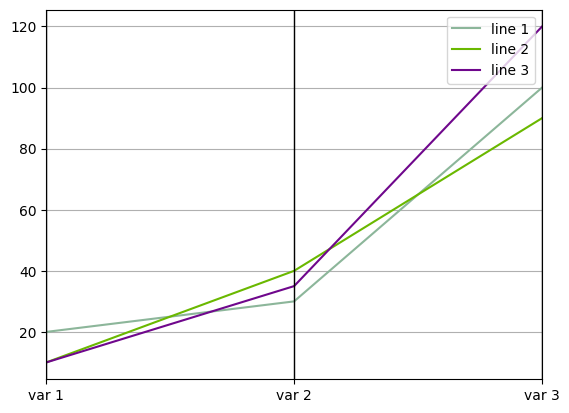

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

df = pd.DataFrame([["line 1",20,30,100],\
    ["line 2",10,40,90],["line 3",10,35,120]],\
    columns=["element","var 1","var 2","var 3"])
parallel_coordinates(df,"element", axvlines=True)
plt.show()


In [ ]:
df

In [ ]:
df

In [3]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("blue"),10))
colors

[<Color red>,
 <Color #ff7100>,
 <Color #ffe300>,
 <Color #af0>,
 <Color #39ff00>,
 <Color #00ff39>,
 <Color #0fa>,
 <Color #00e3ff>,
 <Color #0071ff>,
 <Color blue>]

In [7]:
print(colors[-2])

#0071ff


In [10]:
import numpy as np

# Create data
columns = ['mpg', 'displacement', 'cylinders', 'horsepower', 'weight', 'acceleration']
dct = {}
for column in columns:
    dct[column] = np.random.rand(10)
df = pd.DataFrame(dct)
df

,mpg,displacement,cylinders,horsepower,weight,acceleration
0,0.769564,0.908461,0.105106,0.509153,0.049624,0.701324
1,0.080613,0.829781,0.283498,0.102868,0.075211,0.973912
2,0.963814,0.899212,0.929320,0.863654,0.310858,0.526232
3,0.781091,0.189607,0.823280,0.604387,0.220351,0.145029
4,0.442854,0.467398,0.545279,0.521806,0.690375,0.665477
5,0.994286,0.562126,0.821997,0.477259,0.542493,0.390914
6,0.495650,0.085193,0.655380,0.669586,0.099331,0.888513
7,0.325780,0.458166,0.118158,0.870782,0.419188,0.477520
8,0.819212,0.535954,0.750867,0.592970,0.926295,0.993605
9,0.740730,0.086156,0.136455,0.367331,0.174914,0.996814


In [20]:
xx = list(set(pd.cut(df["mpg"], 3)))
str(xx[0])

'(0.385, 0.69]'

In [ ]:
from matplotlib import ticker

cols = ['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration']
x = [i for i, _ in enumerate(cols)]
colours = ['#2e8ad8', '#cd3785', '#c64c00', '#889a00']

# create dict of categories: colours
#colours = {df['mpg'].cat.categories[i]: colours[i] for i, _ in enumerate(df['mpg'].cat.categories)}

# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

# Get min, max and range for each column
# Normalize the data for each column
min_max_range = {}
for col in cols:
    min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
    df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

# Plot each row
for i, ax in enumerate(axes):
    for idx in df.index:
        mpg_category = df.loc[idx, 'mpg']
        ax.plot(x, df.loc[idx, cols], colours[mpg_category])
    ax.set_xlim([x[i], x[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    norm_min = df[cols[dim]].min()
    norm_range = np.ptp(df[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]])


# Remove space between subplots
plt.subplots_adjust(wspace=0)

# Add legend to plot
plt.legend(
    [plt.Line2D((0,1),(0,0), color=colours[v]) for v in df['mpg']],
    df['mpg'],
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

plt.title("Values of car attributes, by MPG category")

plt.show()